In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from MLE_functions import *
import pickle

manual_metrics_dict = {
    'facebook_nips.tsv': {'Average Path Length': 3.980, 'Pseudo Diameter': 9},
    'hamster.tsv': {'Average Path Length': 3.421, 'Pseudo Diameter': 14},
    'brightkite': {'Average Path Length': 4.859, 'Pseudo Diameter': 18},
    'livemocha': {'Average Path Length': 6.188, 'Pseudo Diameter': 6},
    'Twitter': {'Average Path Length': 6.188, 'Pseudo Diameter': 8},
    'youtube': {'Average Path Length': 5.434 , 'Pseudo Diameter': 24},
    'out.contact': {'Average Path Length':2.415 , 'Pseudo Diameter':4 },
    'cond_mat': {'Average Path Length':5.911 , 'Pseudo Diameter':16 },
    'out.com_dblp': {'Average Path Length':6.752 , 'Pseudo Diameter':23 },
    'out.ca_AstroPh': {'Average Path Length':4.174 , 'Pseudo Diameter':14 }
}


In [2]:
def load_data(file_path, delimiter, nrows=None):
    """ Load the data from a file """
    try:
        data = pd.read_csv(file_path, delimiter=delimiter, header=None, names=['source', 'target'], comment='%', nrows=nrows)
        print(f"Data loaded successfully from {file_path}.")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def create_graph(data):
    """ Create a graph from the dataframe """
    if data is not None and not data.empty:
        G = nx.from_pandas_edgelist(data, 'source', 'target')
        return G
    else:
        print("Data is empty or None. Cannot create graph.")
        return None

In [5]:
def calculate_degree_distribution(G):
    degree = np.array(list(dict(nx.degree(G)).values()))
    k, n_k = np.unique(degree, return_counts=True)
    p_k = n_k / len(G)
    return k, p_k, degree

def plot_degree_distribution(k, p_k, Kmax, mu, sigma):
    plt.figure(figsize=(10, 6))

    # IDP intervals
    intervals = [
        (1, mu-sigma),
        (mu-sigma, mu),
        (mu, mu+sigma),
        (mu+sigma, Kmax)
    ]
    interval_names = ['IDP1', 'IDP2', 'IDP3', 'IDP4']
    colors = ['b', 'g', 'r', 'c']

    for (i, ((start, end), name, color)) in enumerate(zip(intervals, interval_names, colors)):
        mask = (k >= start) & (k <= end)
        plt.plot(k[mask], p_k[mask], 'o', markersize=8, label=f'{name} ({start:.2f}, {end:.2f})', color=color)

    plt.yscale('log')
    plt.xscale('log')

    plt.xlabel('Degree (k)', fontsize=14)
    plt.ylabel('Probability (P(k))', fontsize=14)
    plt.title('Degree Distribution on a Log-Log Scale', fontsize=16)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [6]:
def draw_subgraph(G, num_nodes=50, node_color='red', node_size=50):
    """ Draw a subgraph with a specified number of nodes """
    subgraph_nodes = list(G.nodes())[:num_nodes]
    subgraph = G.subgraph(subgraph_nodes)
    nx.draw(subgraph, with_labels=True, node_color=node_color, node_size=node_size)
    plt.show()

In [7]:
def calculate_remaining_metrics(G, k, p_k, Kmax, mu, sigma, file_path):
    # Calculate the metrics
    metrics = {}

    metrics['Assortativity'] = nx.degree_assortativity_coefficient(G)
    metrics['Average Clustering Coefficient'] = nx.average_clustering(G)  
    metrics['Global Clustering Coefficient'] = nx.transitivity(G)
    metrics['Density'] = nx.density(G)
    metrics['Maximum Degree'] = np.max(k)

    # Calculate max degree centrality
    degree_centrality = nx.degree_centrality(G)
    max_degree_centrality = max(degree_centrality.values())
    metrics['Max Degree Centrality'] = max_degree_centrality

    # Calculate max eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    max_eigenvector_centrality = max(eigenvector_centrality.values())
    metrics['Max Eigenvector Centrality'] = max_eigenvector_centrality 

    # Use manually provided values for Average Path Length and Pseudo Diameter
    manual_metrics = manual_metrics_dict.get(file_path, {})
    metrics['Pseudo Diameter'] = manual_metrics.get('Pseudo Diameter')
    metrics['Average Path Length'] = manual_metrics.get('Average Path Length')

    # Calculate MLE for degree distribution
    result = [0]*6
    result[1] = 'Trunc_PL'
    mle_params = opt_single_dist(np.array(list(dict(G.degree()).values())), result, 1)
    for idx, param in enumerate(mle_params):
        metrics[f'MLE Parameter {idx+1}'] = param

    print(f"\nMetrics for {file_path}:")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    return metrics

In [12]:
def analyze_dataset(file_path, delimiter, nrows=None):
    data = load_data(file_path, delimiter, nrows)
    G = create_graph(data)
    
    if G is not None:
        k, p_k, degree = calculate_degree_distribution(G)
        Kmax = np.max(degree)
        mu = np.mean(degree)
        sigma = np.std(degree)

        print(f"Kmax: {Kmax}")
        print(f"mu: {mu}")
        print(f"sigma: {sigma}")

        plot_degree_distribution(k, p_k, Kmax, mu, sigma)

        # Calculate and print network metrics
        metrics = calculate_remaining_metrics(G, k, p_k, Kmax, mu, sigma, file_path)
        
        # Print the graph G
        print(f"\nGraph for {file_path}:")
        print(G)
        
        # Draw a subgraph
        draw_subgraph(G)

        return metrics


Processing dataset: facebook_nips.tsv
Data loaded successfully from facebook_nips.tsv.
Kmax: 769
mu: 2.064404432132964
sigma: 22.888202491413747


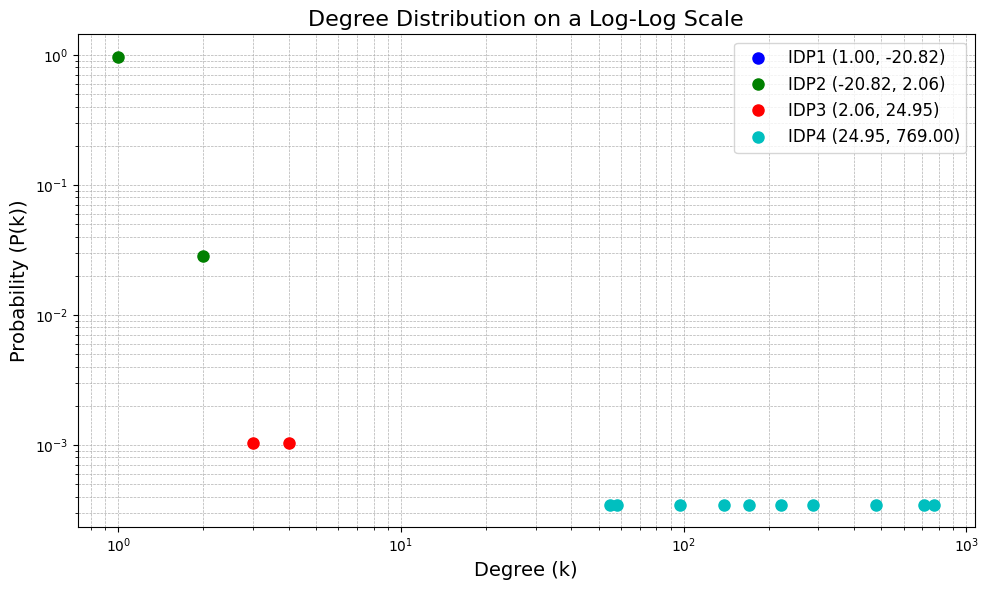


Metrics for facebook_nips.tsv:
Assortativity: -0.6682140067239859
Average Clustering Coefficient: 0.027247421431211827
Global Clustering Coefficient: 0.0003593802862141459
Density: 0.0007150690793671507
Maximum Degree: 769
Max Degree Centrality: 0.2663664703844822
Max Eigenvector Centrality: 0.702481833127399
Pseudo Diameter: 9
Average Path Length: 3.98
MLE Parameter 1: 22.064404432132964
MLE Parameter 2: 4.0

Graph for facebook_nips.tsv:
Graph with 2888 nodes and 2981 edges


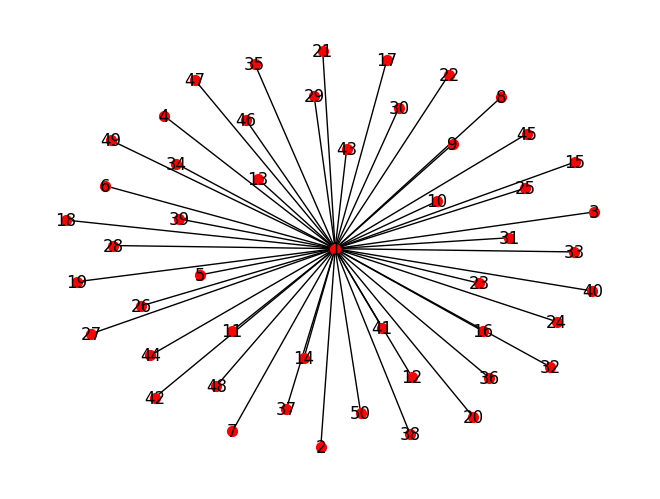


Processing dataset: hamster.tsv
Data loaded successfully from hamster.tsv.
Kmax: 273
mu: 13.710634789777412
sigma: 19.873309222802767


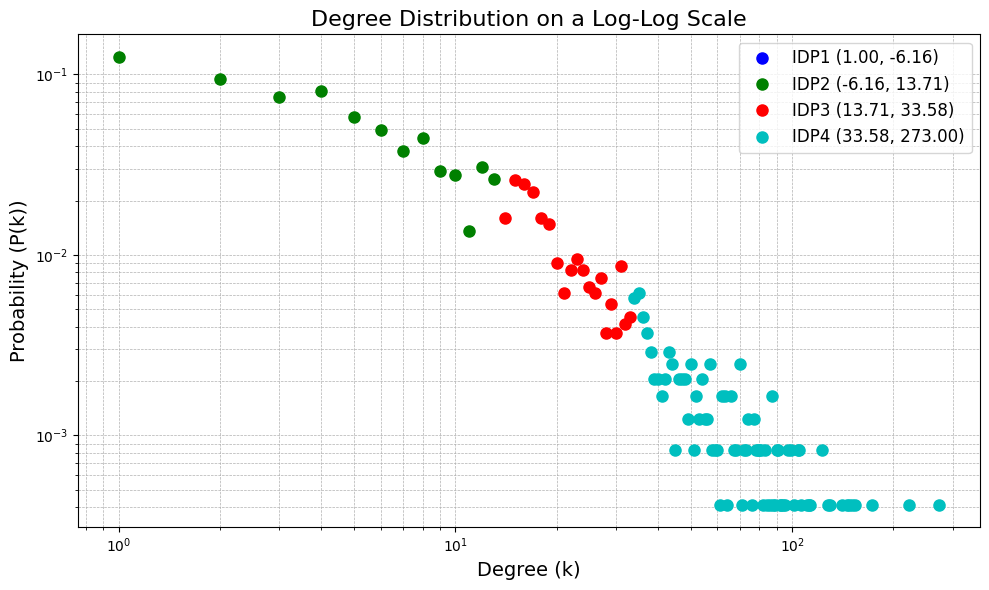


Metrics for hamster.tsv:
Assortativity: 0.04740391079367799
Average Clustering Coefficient: 0.5376264832943294
Global Clustering Coefficient: 0.23143166252210473
Density: 0.005653870016403056
Maximum Degree: 273
Max Degree Centrality: 0.11257731958762887
Max Eigenvector Centrality: 0.2114775038181455
Pseudo Diameter: 14
Average Path Length: 3.421
MLE Parameter 1: 24.80621836628208
MLE Parameter 2: 0.5618704103720661

Graph for hamster.tsv:
Graph with 2426 nodes and 16631 edges


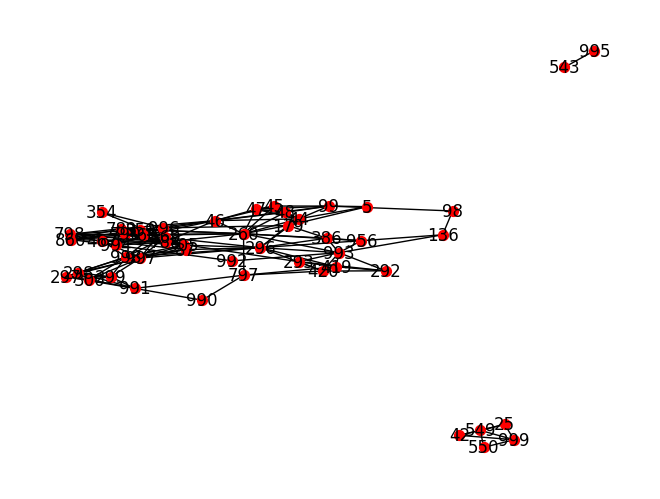


Processing dataset: brightkite
Data loaded successfully from brightkite.
Kmax: 1134
mu: 7.353094731057223
sigma: 20.355554563114094


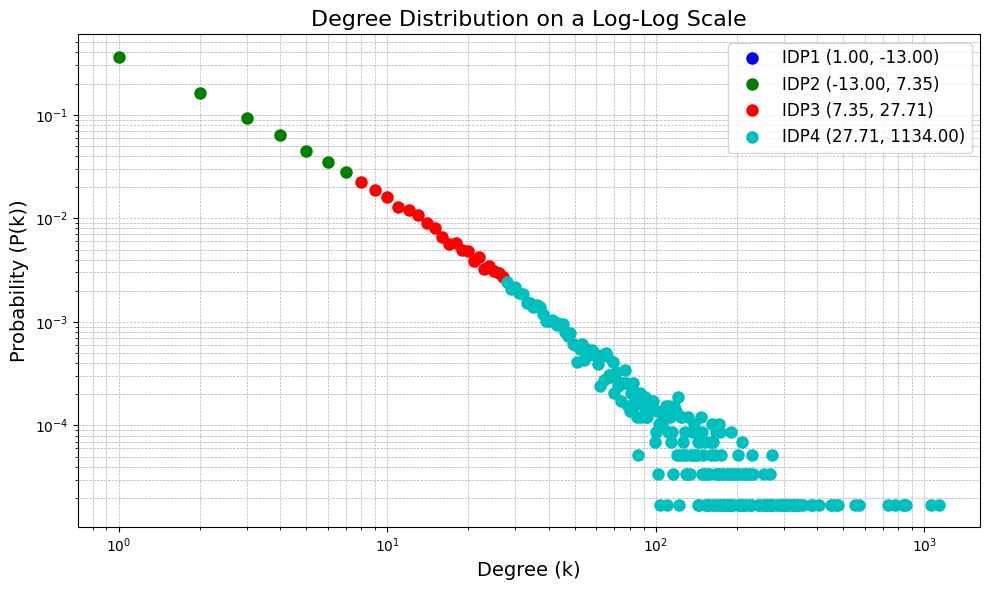


Metrics for brightkite:
Assortativity: 0.01081579631456044
Average Clustering Coefficient: 0.1723259274461329
Global Clustering Coefficient: 0.11056689574171319
Density: 0.00012628324885460737
Maximum Degree: 1134
Max Degree Centrality: 0.019475501056211035
Max Eigenvector Centrality: 0.1520393044887903
Pseudo Diameter: 18
Average Path Length: 4.859
MLE Parameter 1: 27.3530947310568
MLE Parameter 2: 1.1784515321172946

Graph for brightkite:
Graph with 58228 nodes and 214078 edges


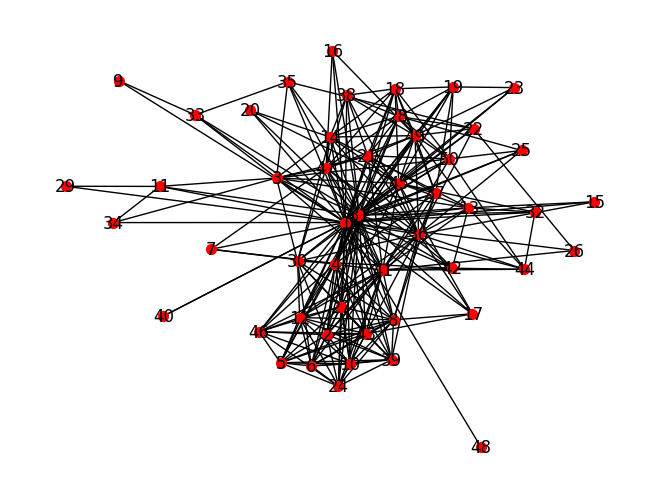


Processing dataset: livemocha
Data loaded successfully from livemocha.
Kmax: 1235
mu: 1.9093655931063453
sigma: 9.052013556844969


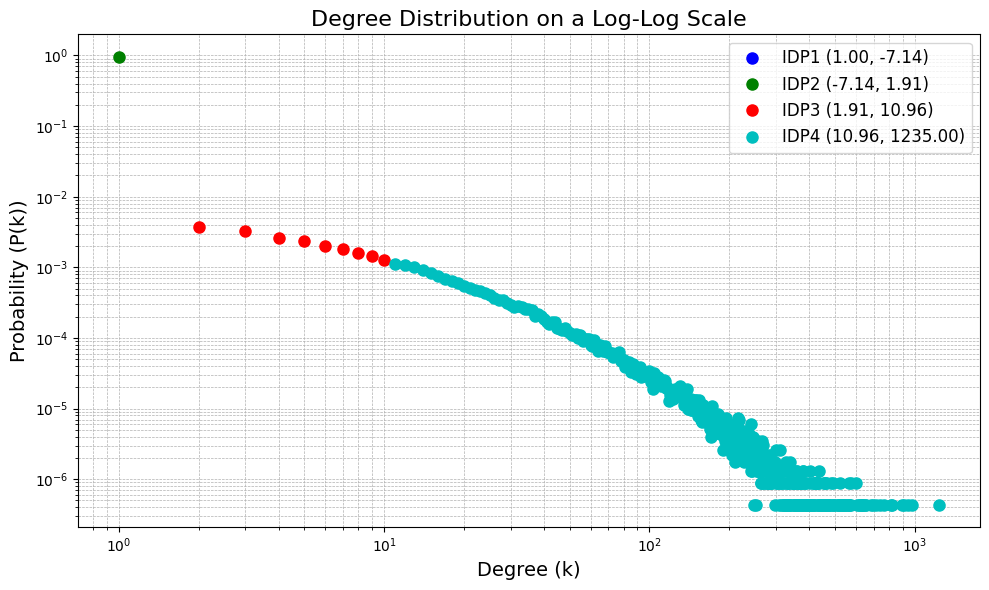


Metrics for livemocha:
Assortativity: -0.23506251573082074
Average Clustering Coefficient: 0.0
Global Clustering Coefficient: 0
Density: 8.311766027912197e-07
Maximum Degree: 1235
Max Degree Centrality: 0.0005376147491885718
Max Eigenvector Centrality: 0.7071067811865474
Pseudo Diameter: 6
Average Path Length: 6.188
MLE Parameter 1: 21.909365593083727
MLE Parameter 2: 3.4103433079367917

Graph for livemocha:
Graph with 2297185 nodes and 2193083 edges


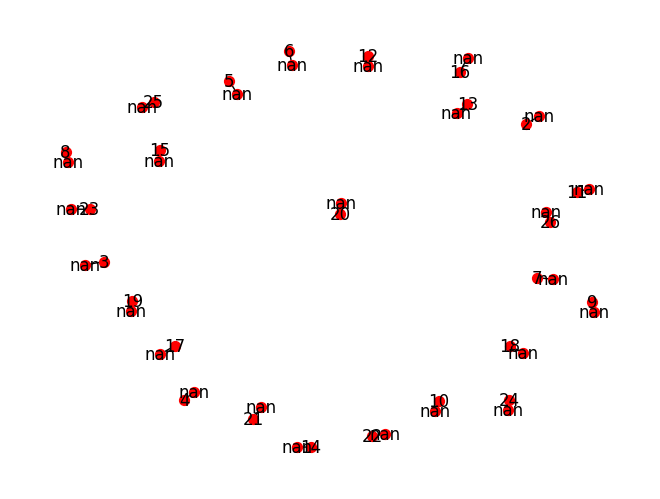


Processing dataset: Twitter
Data loaded successfully from Twitter.
Kmax: 199
mu: 1.2844878455593227
sigma: 2.1217316270360214


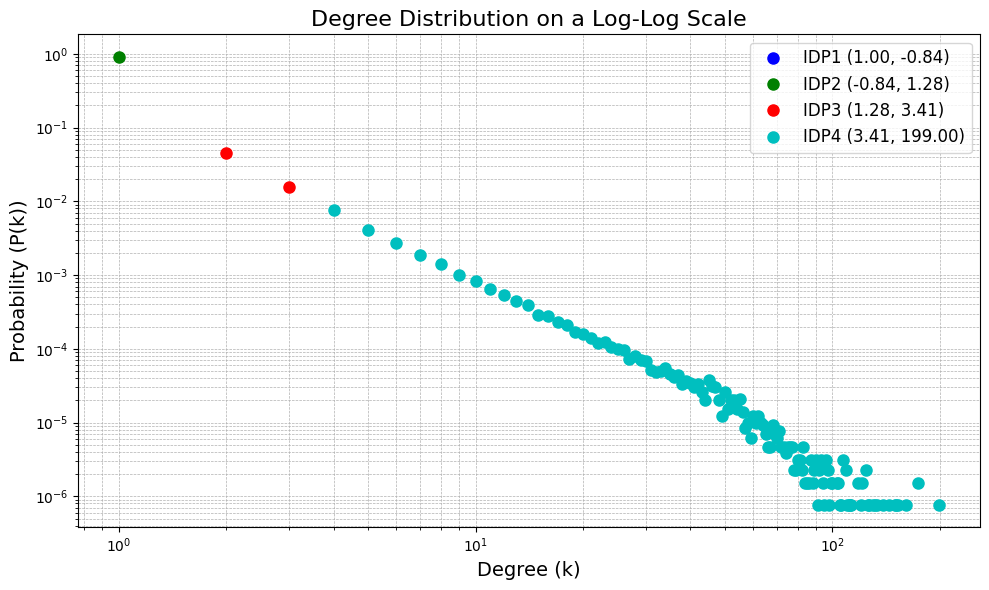


Metrics for Twitter:
Assortativity: -0.08908692064627571
Average Clustering Coefficient: 0.0
Global Clustering Coefficient: 0
Density: 9.882104839463881e-07
Maximum Degree: 199
Max Degree Centrality: 0.00015309906355688363
Max Eigenvector Centrality: 0.7071067811865486
Pseudo Diameter: 8
Average Path Length: 6.188
MLE Parameter 1: 21.284487845558598
MLE Parameter 2: 3.4275744634279843

Graph for Twitter:
Graph with 1299813 nodes and 834797 edges


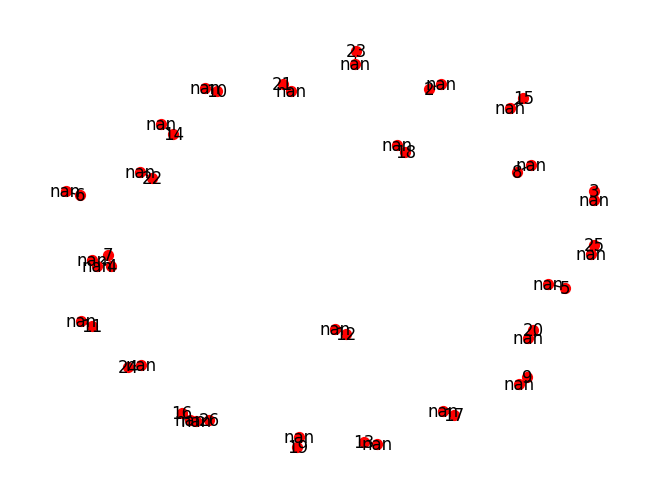


Processing dataset: youtube
Data loaded successfully from youtube.
Kmax: 203
mu: 1.9901960784313726
sigma: 14.10812246790467


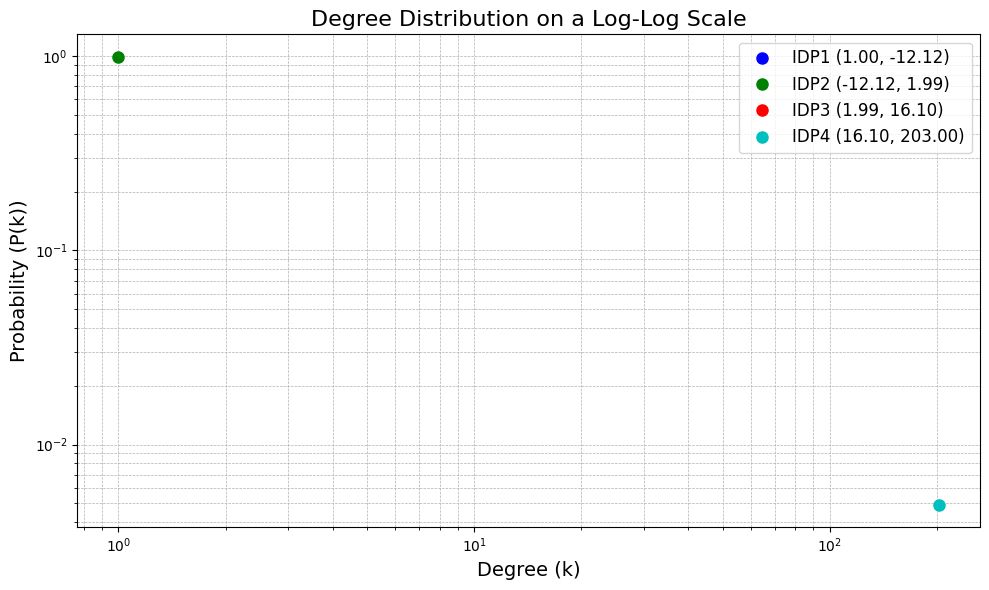


Metrics for youtube:
Assortativity: -1.0
Average Clustering Coefficient: 0.0
Global Clustering Coefficient: 0
Density: 0.00980392156862745
Maximum Degree: 203
Max Degree Centrality: 1.0
Max Eigenvector Centrality: 0.7071067811865467
Pseudo Diameter: 24
Average Path Length: 5.434
MLE Parameter 1: 21.990196078431374
MLE Parameter 2: 3.999999999999993

Graph for youtube:
Graph with 204 nodes and 203 edges


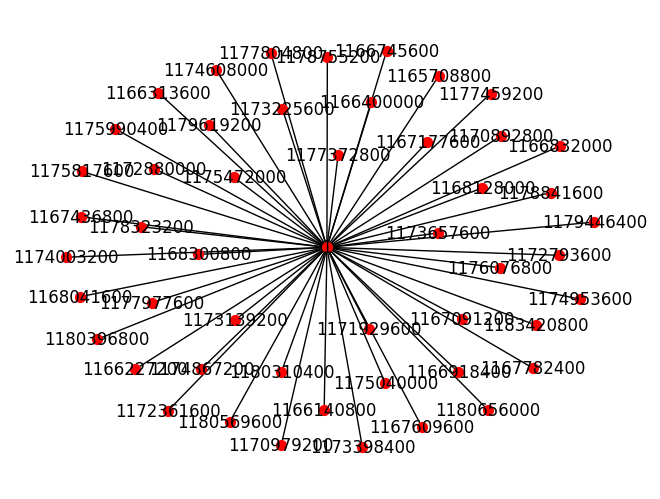


Processing dataset: out.contact
Data loaded successfully from out.contact.
Kmax: 939
mu: 3.5169427710843375
sigma: 30.385551104999827


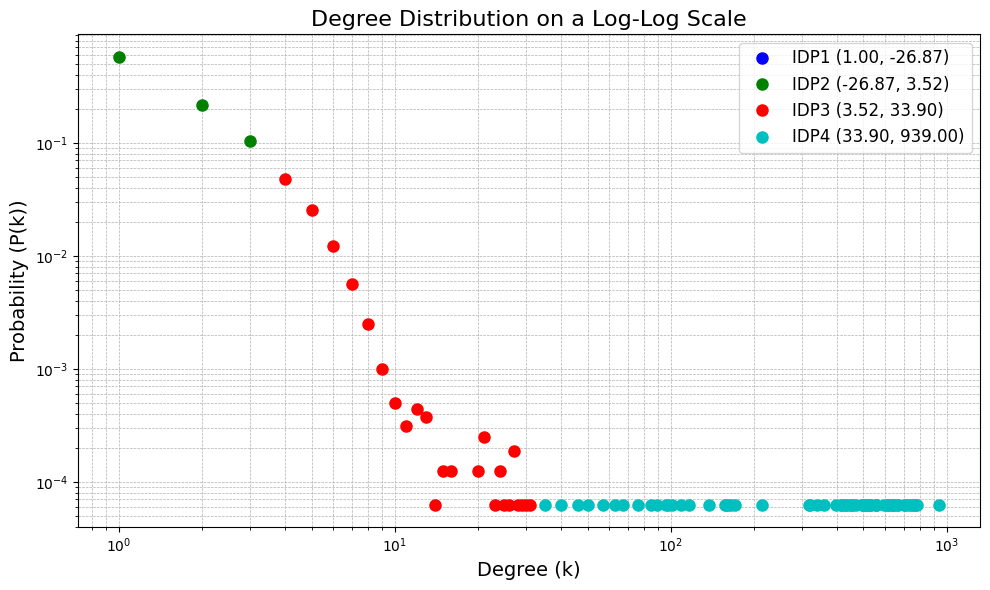


Metrics for out.contact:
Assortativity: -0.7507746008475646
Average Clustering Coefficient: 0.0
Global Clustering Coefficient: 0
Density: 0.0002207055394467736
Maximum Degree: 939
Max Degree Centrality: 0.0589268904926263
Max Eigenvector Centrality: 0.24563427465509516
Pseudo Diameter: 4
Average Path Length: 2.415
MLE Parameter 1: 23.516942771084093
MLE Parameter 2: 1.9457545964380736

Graph for out.contact:
Graph with 15936 nodes and 28023 edges


C:\Users\Aadesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


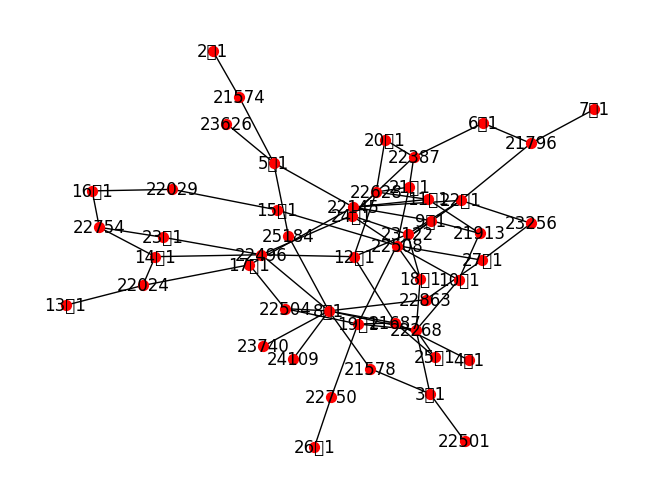


Processing dataset: cond_mat
Data loaded successfully from cond_mat.
Kmax: 1
mu: 1.0
sigma: 0.0


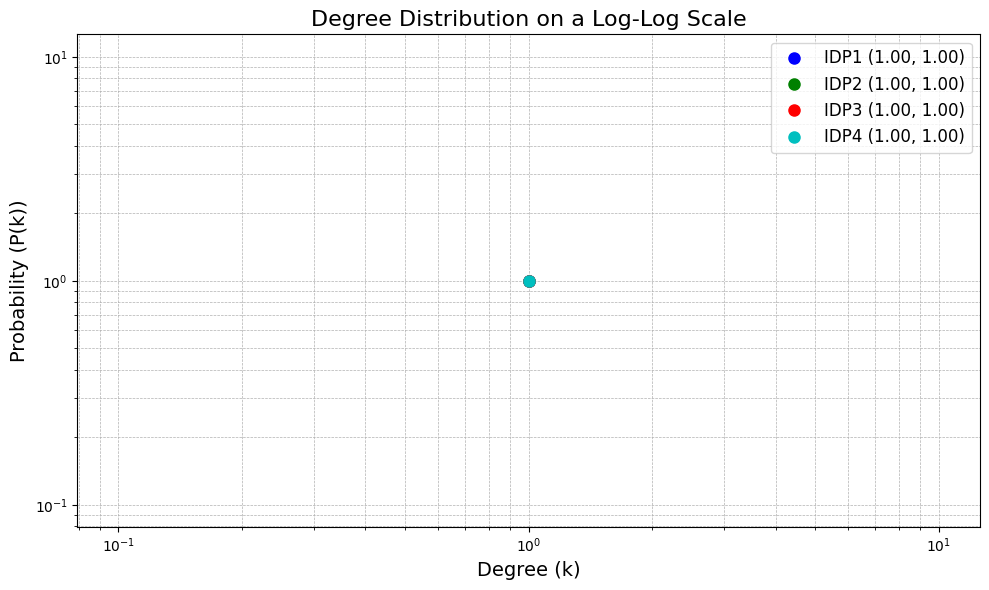

C:\Users\Aadesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\algorithms\assortativity\correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)



Metrics for cond_mat:
Assortativity: nan
Average Clustering Coefficient: 0.0
Global Clustering Coefficient: 0
Density: 4.16567731830357e-06
Maximum Degree: 1
Max Degree Centrality: 4.16567731830357e-06
Max Eigenvector Centrality: 0.16478123459912766
Pseudo Diameter: 16
Average Path Length: 5.911
MLE Parameter 1: 1.0000019298271272
MLE Parameter 2: 1.0

Graph for cond_mat:
Graph with 240058 nodes and 120029 edges


C:\Users\Aadesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


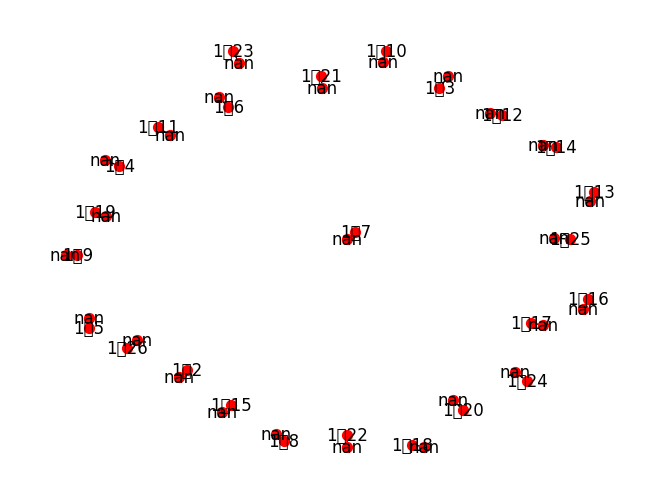


Processing dataset: out.com_dblp
Data loaded successfully from out.com_dblp.
Kmax: 343
mu: 6.622089062697111
sigma: 10.00770765282328


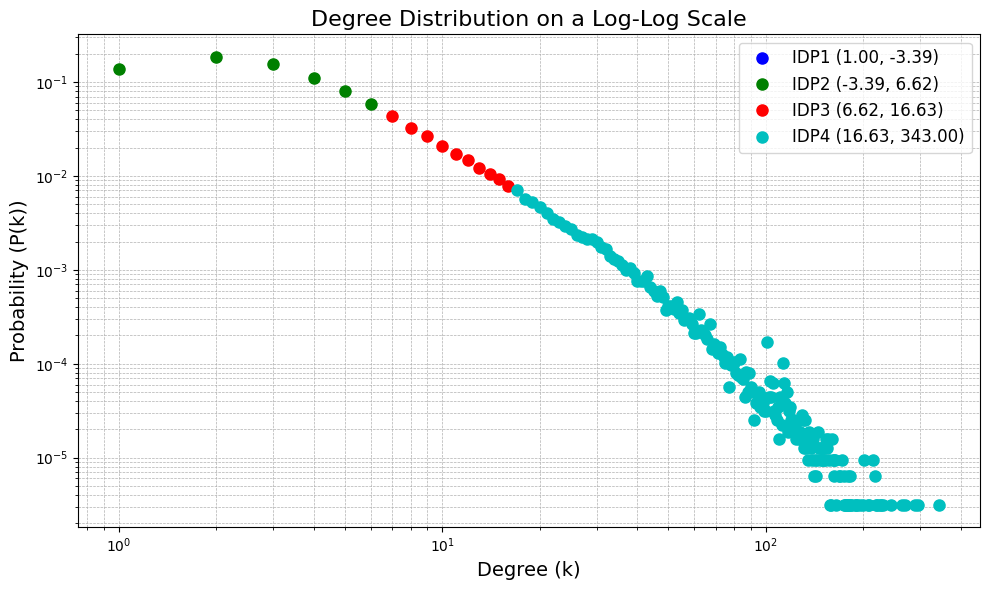


Metrics for out.com_dblp:
Assortativity: 0.2665208308659543
Average Clustering Coefficient: 0.6324308280637565
Global Clustering Coefficient: 0.3063766130023435
Density: 2.08846661642591e-05
Maximum Degree: 343
Max Degree Centrality: 0.001081749343223613
Max Eigenvector Centrality: 0.10083201872350242
Pseudo Diameter: 23
Average Path Length: 6.752
MLE Parameter 1: 9.8991130854225
MLE Parameter 2: 0.5000000000000002

Graph for out.com_dblp:
Graph with 317080 nodes and 1049866 edges


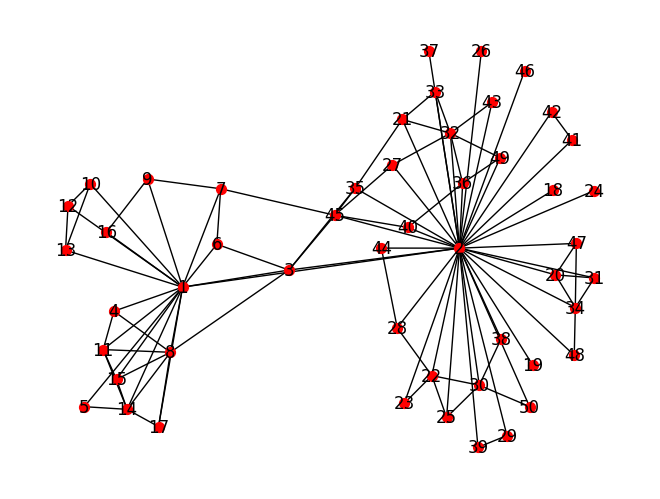


Processing dataset: out.ca_AstroPh
Data loaded successfully from out.ca_AstroPh.
Kmax: 504
mu: 21.101699429971767
sigma: 30.565215937821733


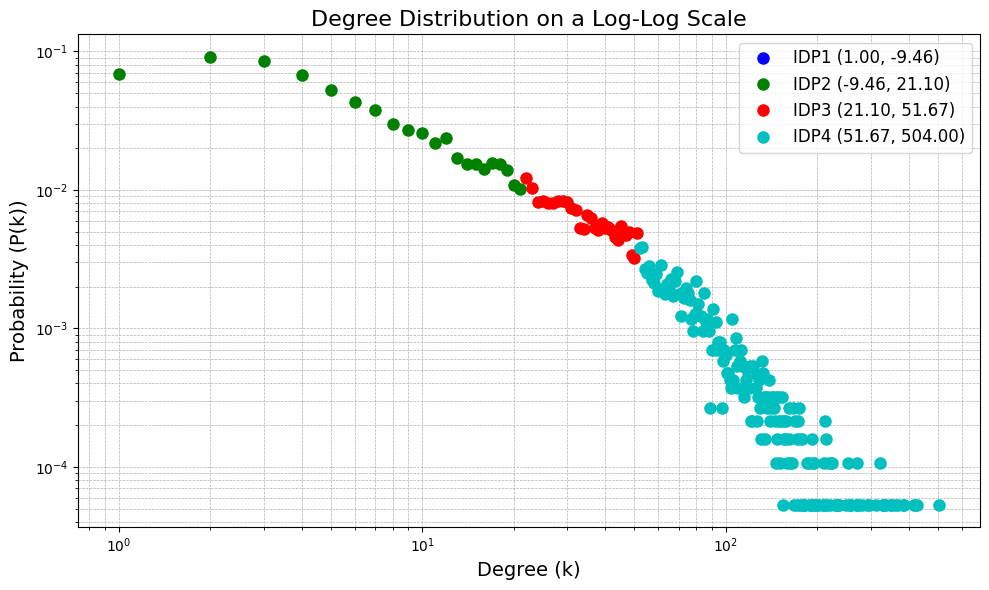


Metrics for out.ca_AstroPh:
Assortativity: 0.2051294310342052
Average Clustering Coefficient: 0.630626835185028
Global Clustering Coefficient: 0.3180015812533629
Density: 0.0011242247964822463
Maximum Degree: 504
Max Degree Centrality: 0.02685135855087906
Max Eigenvector Centrality: 0.14577905309969244
Pseudo Diameter: 14
Average Path Length: 4.174
MLE Parameter 1: 39.773868080388915
MLE Parameter 2: 0.5578431214871715

Graph for out.ca_AstroPh:
Graph with 18771 nodes and 198050 edges


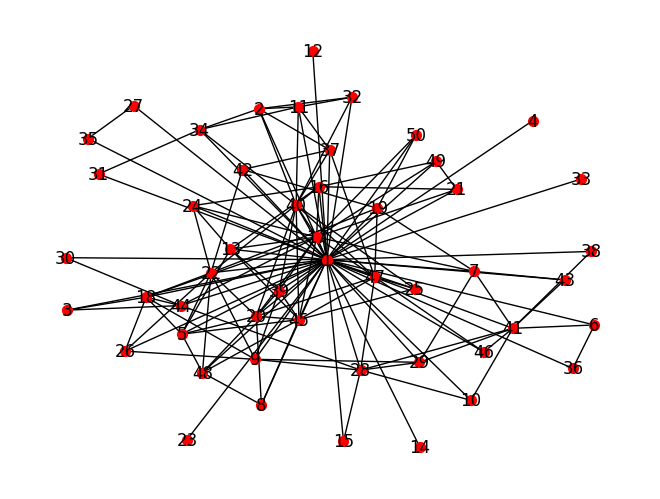

In [13]:
def main():
    datasets = [
        ('facebook_nips.tsv', ' '),
        ('hamster.tsv', '\t'),
        ('brightkite', ' '),
        ('livemocha', ' '),
        ('Twitter', ' '),
        ('youtube', ' '),
        ('out.contact', ' '),
        ('cond_mat', ' '),
        ('out.com_dblp', ' '),
        ('out.ca_AstroPh', ' ')
    ]

    all_metrics = []
    for file_path, delimiter in datasets:
        print(f"\nProcessing dataset: {file_path}")
        metrics = analyze_dataset(file_path, delimiter)
        all_metrics.append(metrics)

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(all_metrics)

    # Standardize the metrics
    scaler = StandardScaler()
    metrics_scaled = scaler.fit_transform(metrics_df)
    
    # Save the standardized metrics to a file
    with open('metrics_scaled.pkl', 'wb') as f:
        pickle.dump(metrics_scaled, f)

if __name__ == "__main__":
    main()

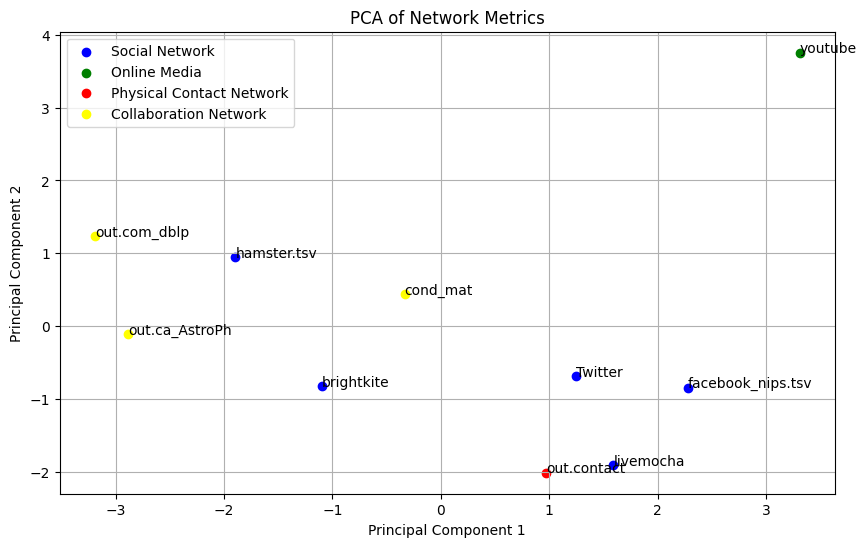

In [17]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load standardized metrics
with open('metrics_scaled.pkl', 'rb') as f:
    metrics_scaled = pickle.load(f)

datasets = [
    'facebook_nips.tsv',
    'hamster.tsv',
    'brightkite',
    'livemocha',
    'Twitter',
    'youtube',
    'out.contact',
    'cond_mat',
    'out.com_dblp',
    'out.ca_AstroPh'
]

import numpy as np

# Replace NaN with the mean of each column
mean_values = np.nanmean(metrics_scaled, axis=0)
indices = np.where(np.isnan(metrics_scaled))
metrics_scaled[indices] = np.take(mean_values, indices[1])

dataset_categories = {
    'facebook_nips.tsv': 'Social Network',
    'hamster.tsv': 'Social Network',
    'brightkite': 'Social Network',
    'livemocha': 'Social Network',
    'Twitter': 'Social Network',
    'youtube': 'Online Media',
    'out.contact': 'Physical Contact Network',
    'cond_mat': 'Collaboration Network',
    'out.com_dblp': 'Collaboration Network',
    'out.ca_AstroPh': 'Collaboration Network'
}

category_colors = {
    'Social Network': 'blue',
    'Online Media': 'green',
    'Physical Contact Network': 'red',
    'Collaboration Network': 'yellow'
}

def plot_pca(metrics_scaled, datasets, dataset_categories, category_colors):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(metrics_scaled)

    principal_df = pd.DataFrame(data=principal_components, 
                                columns=['Principal Component 1', 'Principal Component 2'])

    plt.figure(figsize=(10, 6))
    
    for dataset, (x, y) in zip(datasets, principal_df.values):
        category = dataset_categories[dataset]
        plt.scatter(x, y, color=category_colors[category], label=category)
        plt.annotate(dataset, (x, y))
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Network Metrics')
    plt.grid(True)
    
    # Add a legend to show which color represents which category
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.show()

# Call the function with the new parameters
plot_pca(metrics_scaled, datasets, dataset_categories, category_colors)


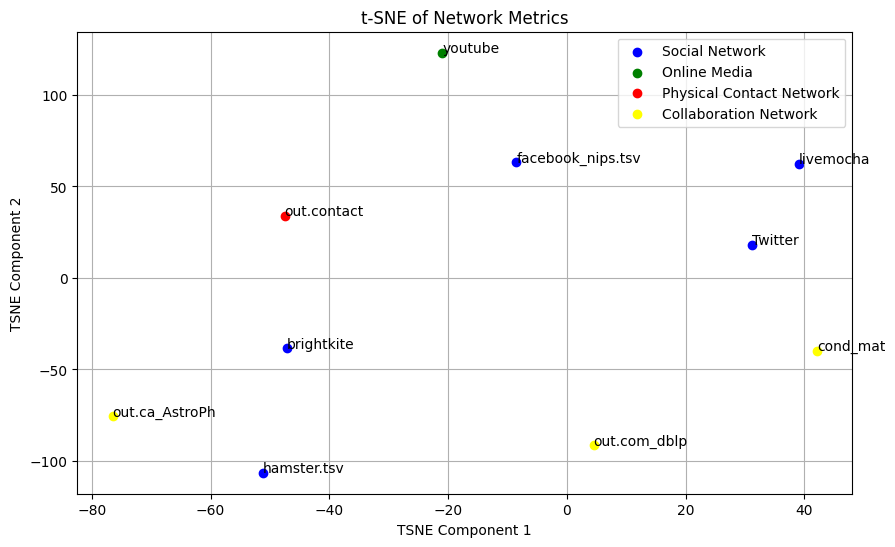

In [18]:
from sklearn.manifold import TSNE

def plot_tsne(metrics_scaled, datasets, dataset_categories, category_colors):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_components = tsne.fit_transform(metrics_scaled)

    tsne_df = pd.DataFrame(data=tsne_components, 
                           columns=['TSNE Component 1', 'TSNE Component 2'])

    plt.figure(figsize=(10, 6))
    
    for dataset, (x, y) in zip(datasets, tsne_df.values):
        category = dataset_categories[dataset]
        plt.scatter(x, y, color=category_colors[category], label=category)
        plt.annotate(dataset, (x, y))
    
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('t-SNE of Network Metrics')
    plt.grid(True)
    
    # Add a legend to show which color represents which category
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.show()

# Call the function with the new parameters
plot_tsne(metrics_scaled, datasets, dataset_categories, category_colors)


C:\Users\Aadesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Aadesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


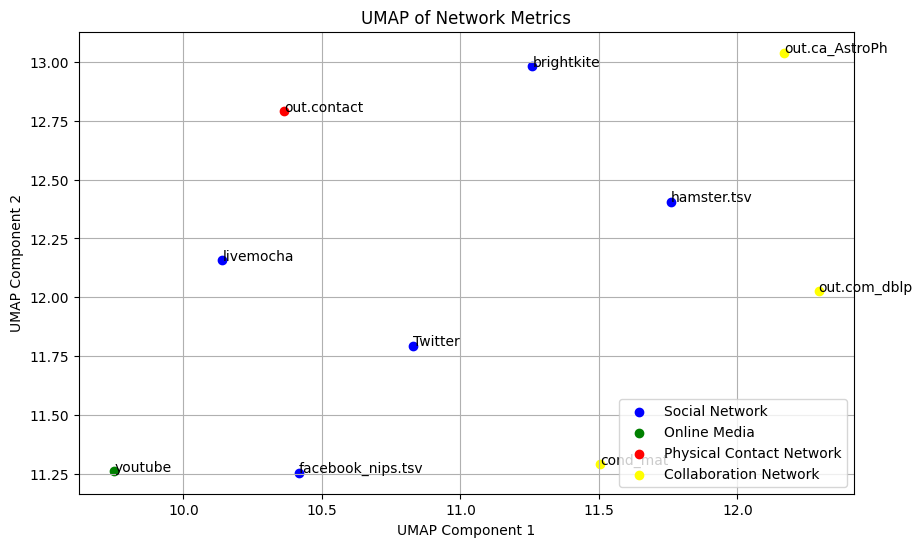

In [19]:
import umap

def plot_umap(metrics_scaled, datasets, dataset_categories, category_colors):
    umap_model = umap.UMAP(n_components=2, random_state=42)
    umap_components = umap_model.fit_transform(metrics_scaled)

    umap_df = pd.DataFrame(data=umap_components, 
                           columns=['UMAP Component 1', 'UMAP Component 2'])

    plt.figure(figsize=(10, 6))
    
    for dataset, (x, y) in zip(datasets, umap_df.values):
        category = dataset_categories[dataset]
        plt.scatter(x, y, color=category_colors[category], label=category)
        plt.annotate(dataset, (x, y))
    
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title('UMAP of Network Metrics')
    plt.grid(True)
    
    # Add a legend to show which color represents which category
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.show()

# Call the function with the new parameters
plot_umap(metrics_scaled, datasets, dataset_categories, category_colors)


2. Clustering Coefficient Comparison

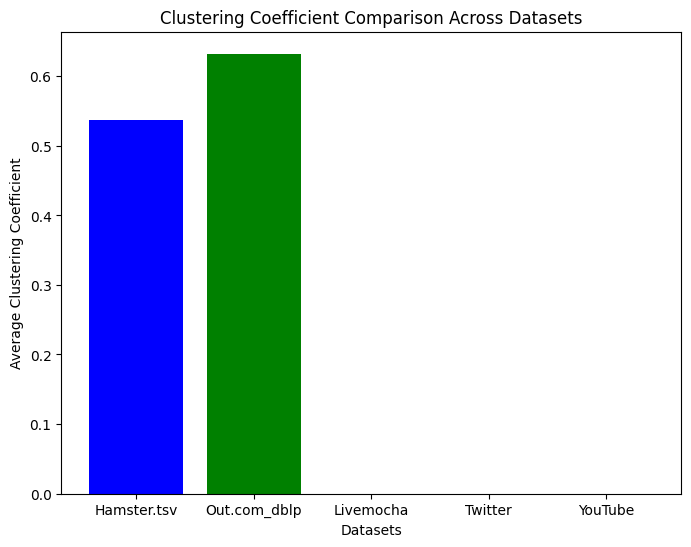

In [20]:
import matplotlib.pyplot as plt

# Clustering coefficients for actual datasets
datasets = ['Hamster.tsv', 'Out.com_dblp', 'Livemocha', 'Twitter', 'YouTube']
clustering_coefficients = [0.5376, 0.6324, 0.0, 0.0, 0.0]

plt.figure(figsize=(8, 6))
plt.bar(datasets, clustering_coefficients, color=['blue', 'green', 'red', 'orange', 'purple'])
plt.xlabel('Datasets')
plt.ylabel('Average Clustering Coefficient')
plt.title('Clustering Coefficient Comparison Across Datasets')
plt.show()

3. Assortativity Patterns Across Datasets

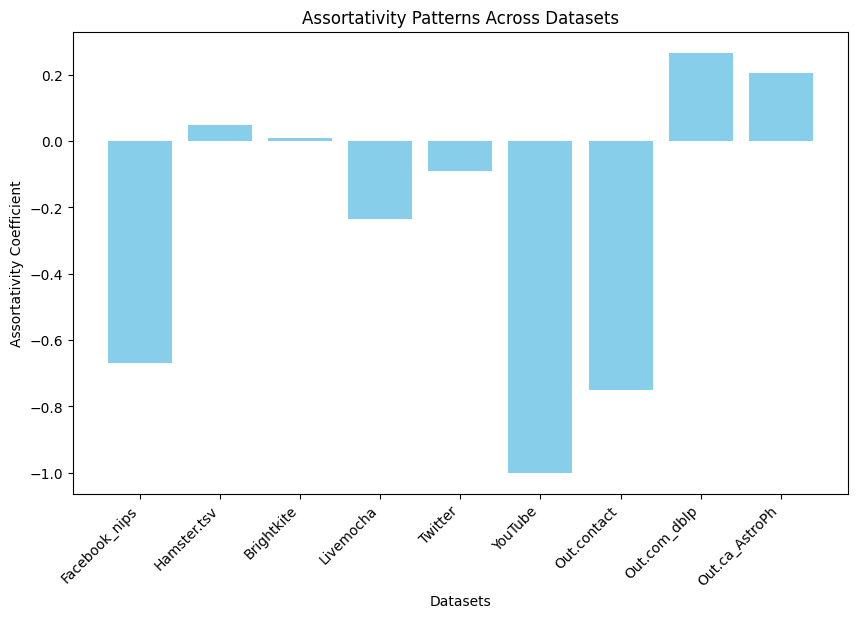

In [22]:
import matplotlib.pyplot as plt

# Assortativity coefficients for actual datasets
datasets = ['Facebook_nips', 'Hamster.tsv', 'Brightkite', 'Livemocha', 'Twitter', 'YouTube', 'Out.contact', 'Out.com_dblp', 'Out.ca_AstroPh']
assortativity_values = [-0.6682, 0.0474, 0.0108, -0.2351, -0.0891, -1.0, -0.7508, 0.2665, 0.2051]

plt.figure(figsize=(10, 6))
plt.bar(datasets, assortativity_values, color='skyblue')
plt.xlabel('Datasets')
plt.ylabel('Assortativity Coefficient')
plt.title('Assortativity Patterns Across Datasets')
plt.xticks(rotation=45, ha='right')
plt.show()
